# Build and train unsupervised simCLR

* Refer to CMC: https://github.com/HobbitLong/CMC/blob/master/train_CMC.py
* Refer to SupContrast: https://github.com/HobbitLong/SupContrast

This notebook is originally for supervised contrastive learning, but it can be easily used for unsupervised contrastive learning. 

For the loss function of supervised contrastive learning, if `labels` is `None` or not passed to it, it degenerates to [SimCLR](https://arxiv.org/abs/2002.05709).

In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

from scipy.stats import spearmanr
#import skimage

import time
import torch
import torch.hub
import torch.nn

import random

# Self-defined functions
from MB_SupCon_utils import Dataset
from MB_SupCon_utils import Encoder

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"  ###### "cuda: 1"
else:
    device = "cpu"

## 1 Load data

In [3]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])

In [4]:
from sklearn.preprocessing import StandardScaler
gut_16s_df_array = StandardScaler().fit_transform(gut_16s_df)
gut_16s_df = pd.DataFrame(gut_16s_df_array, index=gut_16s_df.index, columns=gut_16s_df.columns)

metabolome_df_array = StandardScaler().fit_transform(metabolome_df)
metabolome_df = pd.DataFrame(metabolome_df_array, index=metabolome_df.index, columns=metabolome_df.columns)

In [5]:
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")
gut_16s_df['SubjectID'] = [gut_16s_df.index[i][0:7] for i in range(len(gut_16s_df.index))]
gut_16s_df_subj = pd.merge(left=gut_16s_df, right=subjects, how='left', on='SubjectID')
gut_16s_df_subj.index = gut_16s_df.index
gut_16s_df.drop(columns=['SubjectID'], inplace=True)

In [6]:
# Get indexes for shared patient ids
indexes = list(set(gut_16s_df.index.values) & set(metabolome_df.index.values))
indexes.sort()
print("# of patients: {}".format(len(indexes)))

# of patients: 720


In [7]:
gut_16s_df.shape

(855, 96)

In [8]:
metabolome_df.shape

(981, 724)

## 2 Train unsupervised simCLR

In [9]:
### some parameters used in models
n_out_features = 10
bacth_size = 32
temperature = 0.5

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.001
momentum = 0.9
weight_decay = 0.01
gradient_clip = 3

dropout = 0.6

In [10]:
# train function
from utils_eval import AverageMeter

def train_unsup(epoch, model, criterion_gm, optimizer, train_loader, gradient_clip=10, print_freq=1, device='cuda: 0'):
    """
    One epoch training
    """
    model.train()
    criterion_gm.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    end = time.time()
    
    for idx, (data, index) in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        batch_size = data[list(data.keys())[0]].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        f = model(data)
        # Normalization
        g_norm = f['gut_16s'].pow(2).sum(1, keepdim=True).pow(0.5)
        norm_gut_16s = f['gut_16s'].div(g_norm)
        m_norm = f['metabolome'].pow(2).sum(1, keepdim=True).pow(0.5)
        norm_metabolome = f['metabolome'].div(m_norm)
        
        features = torch.cat((norm_gut_16s, norm_metabolome), dim=1)
        loss = criterion_gm(features.view(batch_size, 2, n_out_features))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        torch.nn.utils.clip_grad_norm_(criterion_gm.parameters(), gradient_clip)
        optimizer.step()

        # ===================meters=====================
        losses.update(loss.item(), batch_size)

        # torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
            # 'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            # 'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t' \
                .format(
                epoch, idx + 1, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
            # print(out_image.shape)
            sys.stdout.flush()

        # ===================debug======================
        if np.isnan(losses.val):
            print(list(model.parameters()))
            print(f['gut_16s'])
            print(f['metabolome'])

            raise Exception("Nan detected")
            break
    
    return losses.avg

In [11]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./feature_data', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

In [12]:
# trian
def train_unsup_simCLR(n_epoch = 1000, batch_size=32, remove_unknown=True):
    
    torch.manual_seed(123)
    np.random.seed(123)
    random.seed(123)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(123)
    
    indexes_noukn = indexes
    
    # Split indexes_train, indexes_val and indexes_test
    np.random.seed(123)
    indexes_train = np.random.choice(indexes_noukn, int(len(indexes_noukn) * 0.7), replace=False)
    indexes_not_train = [_ for _ in indexes_noukn if _ not in indexes_train]
    indexes_val = np.random.choice(indexes_not_train, int(len(indexes_noukn) * 0.15), replace=False)
    indexes_test = [_ for _ in indexes_not_train if _ not in indexes_val]

    print("n train: {}\nn val: {}\nn test: {}".format(len(indexes_train), len(indexes_val), len(indexes_test)))
    
    n_data = len(indexes)
    n_data_train = len(indexes_train)
    n_data_val = len(indexes_val)
    n_data_test = len(indexes_test)
    
    from supervised_loss import SupConLoss

    # Generator
    train_set = Dataset(indexes_train, {"gut_16s": gut_16s_df,
                                        "metabolome": metabolome_df})
    val_set = Dataset(indexes_val, {"gut_16s": gut_16s_df,
                                    "metabolome": metabolome_df})
    if len(indexes_train)%batch_size==1:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=bacth_size, shuffle=True, num_workers=0, drop_last=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

    # Set model
    model = Encoder(net_dict={"gut_16s": [gut_16s_df.shape[1], 64, 32], 
                             "metabolome": [metabolome_df.shape[1], 256, 64]}, 
                   n_out_features=n_out_features, dropout_rate=dropout).to(device)
    criterion_gm = SupConLoss(temperature=temperature, base_temperature=temperature)

    # Set optimizer
    optimizer = torch.optim.SGD(model.parameters(), 
                                  lr=lr, 
                                  momentum=momentum,
                                  weight_decay=weight_decay)

    results = pd.DataFrame(index=['gm_loss', 'val_gm_loss', 'val_gm_corr', 'val_gm_p', 'run_time'],
                          columns=['SGD_10dim'])

    start_time = time.time()

    # =========================
    hist = dict()
    hist['gm_loss'] = []
    hist['val_gm_loss'] = []

    hist['val_gm_corr'] = []
    hist['val_gm_p'] = []

    for epoch in range(n_epoch):
        # Train
        gm_loss = train_unsup(epoch, model, criterion_gm, optimizer, train_loader, gradient_clip=gradient_clip, 
                  print_freq=10, device=device)
        hist['gm_loss'].append(gm_loss)

        # Val
        model.eval()
        criterion_gm.eval()
        feat_gut_16ss = []
        feat_metabolomes = []
        val_losses = AverageMeter()

        with torch.no_grad():
            for idx, (data, index) in enumerate(val_loader):
                batch_size = data[list(data.keys())[0]].size(0)
                index = index.to(device)
                for _ in data.keys():
                    data[_] = data[_].float().to(device)

                # ===================forward=====================
                f = model(data)
                # Normalization
                g_norm = f['gut_16s'].pow(2).sum(1, keepdim=True).pow(0.5)
                norm_gut_16s = f['gut_16s'].div(g_norm)
                m_norm = f['metabolome'].pow(2).sum(1, keepdim=True).pow(0.5)
                norm_metabolome = f['metabolome'].div(m_norm)

                if batch_size > 1:
                    feat_gut_16ss.extend(f['gut_16s'].cpu().numpy().squeeze())
                    feat_metabolomes.extend(f['metabolome'].cpu().numpy().squeeze())
                else:
                    feat_gut_16ss.append(f['gut_16s'].cpu().numpy().squeeze())
                    feat_metabolomes.append(f['metabolome'].cpu().numpy().squeeze())

                val_features = torch.cat((norm_gut_16s, norm_metabolome), dim=1)
                val_loss = criterion_gm(val_features.view(batch_size, 2, n_out_features))
                val_losses.update(val_loss.item(), batch_size)

            hist['val_gm_loss'].append(val_losses.avg)
            print('\tval_loss\t{}'.format(val_losses.avg))

        # Calculate correlation, prind and append
        feat_gut_16ss = np.array(feat_gut_16ss)
        feat_metabolomes = np.array(feat_metabolomes)
        corr = []
        pv = []
        for i in range(n_out_features):
            corr_res = spearmanr(feat_gut_16ss[:, i], feat_metabolomes[:, i])
            corr.append(corr_res.correlation)
            pv.append(corr_res.pvalue)
        gm_corr = np.average(corr)
        gm_pv = np.median(pv) ## median of p-values
        hist['val_gm_corr'].append(gm_corr)
        hist['val_gm_p'].append(gm_pv)

    end_time = time.time()

    results.iloc[0,0] = hist['gm_loss']
    results.iloc[1,0] = hist['val_gm_loss']
    results.iloc[2,0] = hist['val_gm_corr']
    results.iloc[3,0] = hist['val_gm_p']
    results.iloc[4,0] = end_time-start_time

    print('Training time (epoch={}): {}\n'.format(n_epoch, end_time-start_time))

    os.makedirs('./results/simCLR', exist_ok=True)

    results.to_pickle('./results/simCLR/simCLR.pkl')

    torch.save({
                'epoch': n_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, './models/simCLR_{}epoch_SGD.pth'.format(n_epoch))
    
    os.makedirs('./data/index/simCLR', exist_ok=True)
    np.savetxt('./data/index/simCLR/indexes_noukn.txt', indexes_noukn, fmt='%s')
    np.savetxt('./data/index/simCLR/indexes_train.txt', indexes_train, fmt='%s')
    np.savetxt('./data/index/simCLR/indexes_val.txt', indexes_val, fmt='%s')
    np.savetxt('./data/index/simCLR/indexes_test.txt', indexes_test, fmt='%s')
    return model, optimizer, results, (indexes_noukn, indexes_train, indexes_val, indexes_test)


## 3 Store feature data (embeddings)

In [13]:
# features
def gut_16s_features(index, model):
    gut_16s = gut_16s_df.loc[index, :].values
    # Forward with gut_16s_net
    model.eval()
    with torch.no_grad():
        _gut_16s_feature = torch.tensor([gut_16s]).float()
        for i, _module in enumerate(list(model.gut_16s.modules())[0]): # enumerate in ModuleList
            _gut_16s_feature = _module(torch.tensor([_gut_16s_feature.squeeze().cpu().numpy()]).float().to(device))

    _gut_16s_feature = _gut_16s_feature.squeeze().cpu().numpy()
    return _gut_16s_feature

def metabolome_features(index, model):
    metabolome = metabolome_df.loc[index, :].values
    # Forward with metabolome_net
    model.eval()
    with torch.no_grad():
        _metabolome_feature = torch.tensor([metabolome]).float()
        for i, _module in enumerate(list(model.metabolome.modules())[0]):
            _metabolome_feature = _module(torch.tensor([_metabolome_feature.squeeze().cpu().numpy()]).float().to(device))

    _metabolome_feature = _metabolome_feature.squeeze().cpu().numpy()
    return _metabolome_feature

In [14]:
def store_embedding_unsup(index, model, which_dataset):
    """
    which_dataset: {'all', 'train', 'val', 'test'}
    """
    feat_gut_16s = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_gut_16s.iloc[i,:] = gut_16s_features(index[i], model)
    feat_gut_16s['SubjectID'] = [feat_gut_16s.index[i][0:7] for i in range(len(index))]
    gut_16s_feat_subj = pd.merge(left=feat_gut_16s, right=subjects, how='left', on='SubjectID')
    gut_16s_feat_subj.index = feat_gut_16s.index

    feat_metabolome = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_metabolome.iloc[i,:] = metabolome_features(index[i], model)
    feat_metabolome['SubjectID'] = [feat_metabolome.index[i][0:7] for i in range(len(index))]
    metabolome_feat_subj = pd.merge(left=feat_metabolome, right=subjects, how='left', on='SubjectID')
    metabolome_feat_subj.index = feat_metabolome.index

    feat_gut_16s = feat_gut_16s.drop(columns='SubjectID')
    feat_metabolome = feat_metabolome.drop(columns='SubjectID')

    save_folder = './feature_data/simCLR/{}'.format(which_dataset)
    
    os.makedirs(save_folder, exist_ok=True)
        
    feat_gut_16s.to_pickle(os.path.join(save_folder, 'feat_gut_16s_{}.pkl'.format(which_dataset)))
    feat_metabolome.to_pickle(os.path.join(save_folder, 'feat_metabolome_{}.pkl'.format(which_dataset)))
    gut_16s_feat_subj.to_pickle(os.path.join(save_folder, 'gut_16s_feat_subj_{}.pkl'.format(which_dataset)))
    metabolome_feat_subj.to_pickle(os.path.join(save_folder, 'metabolome_feat_subj_{}.pkl'.format(which_dataset)))

---

### Train simCLR and store embeddings

In [15]:
model_simCLR, optimizer_simCLR, results_simCLR, index_set_simCLR = train_unsup_simCLR(n_epoch=1200)

n train: 503
n val: 108
n test: 109
Epoch: [0][10/16]	loss 7.077 (7.169)	
	val_loss	6.7641975084940595
Epoch: [1][10/16]	loss 7.234 (7.200)	
	val_loss	6.764769077301025
Epoch: [2][10/16]	loss 7.151 (7.157)	
	val_loss	6.767625985322176
Epoch: [3][10/16]	loss 7.368 (7.182)	
	val_loss	6.755046809161151
Epoch: [4][10/16]	loss 7.322 (7.217)	
	val_loss	6.748824649386936
Epoch: [5][10/16]	loss 7.075 (7.130)	
	val_loss	6.7440248595343695
Epoch: [6][10/16]	loss 7.230 (7.204)	
	val_loss	6.728472250479239
Epoch: [7][10/16]	loss 7.123 (7.167)	
	val_loss	6.715468936496311
Epoch: [8][10/16]	loss 7.336 (7.158)	
	val_loss	6.719338734944661
Epoch: [9][10/16]	loss 7.147 (7.140)	
	val_loss	6.708572458337854
Epoch: [10][10/16]	loss 7.009 (7.068)	
	val_loss	6.68945492638482
Epoch: [11][10/16]	loss 6.971 (7.160)	
	val_loss	6.681990800080476
Epoch: [12][10/16]	loss 7.264 (7.138)	
	val_loss	6.688417364049841
Epoch: [13][10/16]	loss 7.273 (7.133)	
	val_loss	6.6763607660929365
Epoch: [14][10/16]	loss 7.257 (7.1

	val_loss	5.988706394478127
Epoch: [122][10/16]	loss 6.612 (6.102)	
	val_loss	6.005967775980632
Epoch: [123][10/16]	loss 6.160 (6.197)	
	val_loss	5.9900994654055
Epoch: [124][10/16]	loss 6.217 (6.142)	
	val_loss	5.993735507682517
Epoch: [125][10/16]	loss 6.135 (6.043)	
	val_loss	5.988173131589536
Epoch: [126][10/16]	loss 6.047 (6.098)	
	val_loss	5.987257180390535
Epoch: [127][10/16]	loss 5.879 (6.094)	
	val_loss	5.96195810812491
Epoch: [128][10/16]	loss 5.768 (6.081)	
	val_loss	5.969782829284668
Epoch: [129][10/16]	loss 5.939 (6.107)	
	val_loss	5.975235744758889
Epoch: [130][10/16]	loss 5.743 (6.122)	
	val_loss	5.945444442607738
Epoch: [131][10/16]	loss 6.143 (6.104)	
	val_loss	5.95321602291531
Epoch: [132][10/16]	loss 5.809 (6.032)	
	val_loss	5.981165250142415
Epoch: [133][10/16]	loss 5.999 (6.001)	
	val_loss	5.94261755766692
Epoch: [134][10/16]	loss 5.766 (5.928)	
	val_loss	5.9670628441704645
Epoch: [135][10/16]	loss 6.056 (5.946)	
	val_loss	5.940280349166305
Epoch: [136][10/16]	loss

	val_loss	5.6562961649011685
Epoch: [243][10/16]	loss 5.518 (5.302)	
	val_loss	5.656260384453668
Epoch: [244][10/16]	loss 5.013 (5.337)	
	val_loss	5.664142714606391
Epoch: [245][10/16]	loss 5.379 (5.313)	
	val_loss	5.670813878377278
Epoch: [246][10/16]	loss 5.557 (5.309)	
	val_loss	5.668159387729786
Epoch: [247][10/16]	loss 5.112 (5.351)	
	val_loss	5.673744369436194
Epoch: [248][10/16]	loss 5.308 (5.357)	
	val_loss	5.668154433921531
Epoch: [249][10/16]	loss 5.163 (5.379)	
	val_loss	5.624952254471956
Epoch: [250][10/16]	loss 5.273 (5.340)	
	val_loss	5.621681628403841
Epoch: [251][10/16]	loss 5.306 (5.338)	
	val_loss	5.65965559747484
Epoch: [252][10/16]	loss 5.764 (5.369)	
	val_loss	5.673178478523537
Epoch: [253][10/16]	loss 5.286 (5.301)	
	val_loss	5.662370204925537
Epoch: [254][10/16]	loss 5.531 (5.222)	
	val_loss	5.6576104164123535
Epoch: [255][10/16]	loss 5.260 (5.169)	
	val_loss	5.657897913897479
Epoch: [256][10/16]	loss 5.207 (5.270)	
	val_loss	5.6473574814973055
Epoch: [257][10/16

	val_loss	5.642297285574454
Epoch: [364][10/16]	loss 5.111 (5.055)	
	val_loss	5.6379809909396705
Epoch: [365][10/16]	loss 5.458 (5.125)	
	val_loss	5.623101675951922
Epoch: [366][10/16]	loss 5.065 (5.079)	
	val_loss	5.644449401784827
Epoch: [367][10/16]	loss 5.122 (5.057)	
	val_loss	5.626596415484393
Epoch: [368][10/16]	loss 5.325 (5.103)	
	val_loss	5.641827053493923
Epoch: [369][10/16]	loss 4.874 (5.128)	
	val_loss	5.6566986861052335
Epoch: [370][10/16]	loss 4.995 (5.169)	
	val_loss	5.655176922127053
Epoch: [371][10/16]	loss 5.230 (5.134)	
	val_loss	5.660985134266041
Epoch: [372][10/16]	loss 5.124 (5.135)	
	val_loss	5.6458499873126
Epoch: [373][10/16]	loss 5.143 (5.073)	
	val_loss	5.665564325120714
Epoch: [374][10/16]	loss 4.882 (5.088)	
	val_loss	5.672425340723108
Epoch: [375][10/16]	loss 5.255 (5.122)	
	val_loss	5.637683585838035
Epoch: [376][10/16]	loss 5.058 (5.077)	
	val_loss	5.648291446544506
Epoch: [377][10/16]	loss 5.184 (5.090)	
	val_loss	5.658075782987806
Epoch: [378][10/16]	

	val_loss	5.674093582012035
Epoch: [485][10/16]	loss 4.905 (5.034)	
	val_loss	5.655880945700186
Epoch: [486][10/16]	loss 4.985 (4.964)	
	val_loss	5.673455035244977
Epoch: [487][10/16]	loss 5.110 (4.964)	
	val_loss	5.705065020808467
Epoch: [488][10/16]	loss 4.838 (4.967)	
	val_loss	5.706225836718524
Epoch: [489][10/16]	loss 5.121 (4.935)	
	val_loss	5.715663238807961
Epoch: [490][10/16]	loss 5.042 (5.026)	
	val_loss	5.720177403202763
Epoch: [491][10/16]	loss 5.119 (4.981)	
	val_loss	5.722089061030635
Epoch: [492][10/16]	loss 4.986 (4.997)	
	val_loss	5.720548824027732
Epoch: [493][10/16]	loss 4.840 (5.057)	
	val_loss	5.688716897258052
Epoch: [494][10/16]	loss 4.998 (4.913)	
	val_loss	5.671418190002441
Epoch: [495][10/16]	loss 5.012 (4.986)	
	val_loss	5.666199666482431
Epoch: [496][10/16]	loss 4.983 (4.956)	
	val_loss	5.664819832201357
Epoch: [497][10/16]	loss 4.943 (4.951)	
	val_loss	5.679135340231436
Epoch: [498][10/16]	loss 4.735 (5.006)	
	val_loss	5.670061455832587
Epoch: [499][10/16]	

	val_loss	5.689264368127893
Epoch: [606][10/16]	loss 4.947 (5.026)	
	val_loss	5.7010956870185
Epoch: [607][10/16]	loss 4.860 (4.896)	
	val_loss	5.720145631719519
Epoch: [608][10/16]	loss 5.068 (4.873)	
	val_loss	5.668588814912019
Epoch: [609][10/16]	loss 4.937 (4.918)	
	val_loss	5.634176042344835
Epoch: [610][10/16]	loss 5.047 (4.913)	
	val_loss	5.5890979678542525
Epoch: [611][10/16]	loss 4.718 (4.905)	
	val_loss	5.619543146204065
Epoch: [612][10/16]	loss 5.066 (4.978)	
	val_loss	5.653592922069408
Epoch: [613][10/16]	loss 4.884 (4.944)	
	val_loss	5.663710452892162
Epoch: [614][10/16]	loss 4.848 (4.928)	
	val_loss	5.628322813245985
Epoch: [615][10/16]	loss 5.472 (5.055)	
	val_loss	5.643381471987124
Epoch: [616][10/16]	loss 4.853 (4.857)	
	val_loss	5.611859657146312
Epoch: [617][10/16]	loss 4.761 (4.923)	
	val_loss	5.63247663003427
Epoch: [618][10/16]	loss 4.795 (4.903)	
	val_loss	5.625890519883898
Epoch: [619][10/16]	loss 4.941 (4.876)	
	val_loss	5.623742368486193
Epoch: [620][10/16]	lo

	val_loss	5.6451875721966776
Epoch: [727][10/16]	loss 4.669 (4.856)	
	val_loss	5.677115934866446
Epoch: [728][10/16]	loss 4.634 (4.795)	
	val_loss	5.6838020395349576
Epoch: [729][10/16]	loss 4.897 (4.729)	
	val_loss	5.7157868985776545
Epoch: [730][10/16]	loss 4.821 (4.803)	
	val_loss	5.6949883213749635
Epoch: [731][10/16]	loss 4.926 (4.808)	
	val_loss	5.6873147752549915
Epoch: [732][10/16]	loss 5.012 (4.850)	
	val_loss	5.681033240424262
Epoch: [733][10/16]	loss 4.747 (4.869)	
	val_loss	5.628418039392542
Epoch: [734][10/16]	loss 4.776 (4.818)	
	val_loss	5.6252602294639305
Epoch: [735][10/16]	loss 4.847 (4.875)	
	val_loss	5.63477502045808
Epoch: [736][10/16]	loss 4.761 (4.806)	
	val_loss	5.6131363268251775
Epoch: [737][10/16]	loss 4.805 (4.947)	
	val_loss	5.640168190002441
Epoch: [738][10/16]	loss 4.936 (4.861)	
	val_loss	5.659181912740071
Epoch: [739][10/16]	loss 4.708 (4.803)	
	val_loss	5.623913941559969
Epoch: [740][10/16]	loss 5.165 (4.795)	
	val_loss	5.660961521996392
Epoch: [741][1

Epoch: [847][10/16]	loss 4.792 (4.834)	
	val_loss	5.672968175676134
Epoch: [848][10/16]	loss 4.928 (4.765)	
	val_loss	5.6327310491491245
Epoch: [849][10/16]	loss 4.702 (4.714)	
	val_loss	5.674336186161748
Epoch: [850][10/16]	loss 4.601 (4.791)	
	val_loss	5.68670438837122
Epoch: [851][10/16]	loss 4.753 (4.779)	
	val_loss	5.692252141458017
Epoch: [852][10/16]	loss 5.016 (4.766)	
	val_loss	5.68565269752785
Epoch: [853][10/16]	loss 5.129 (4.886)	
	val_loss	5.661918887385616
Epoch: [854][10/16]	loss 4.613 (4.794)	
	val_loss	5.634700775146484
Epoch: [855][10/16]	loss 4.870 (4.891)	
	val_loss	5.598274019029406
Epoch: [856][10/16]	loss 4.602 (4.706)	
	val_loss	5.67300143065276
Epoch: [857][10/16]	loss 4.842 (4.673)	
	val_loss	5.6795922738534435
Epoch: [858][10/16]	loss 4.806 (4.800)	
	val_loss	5.658931555571379
Epoch: [859][10/16]	loss 4.892 (4.895)	
	val_loss	5.66986627931948
Epoch: [860][10/16]	loss 4.924 (4.804)	
	val_loss	5.678207238515218
Epoch: [861][10/16]	loss 4.631 (4.716)	
	val_loss	

	val_loss	5.68355671564738
Epoch: [968][10/16]	loss 5.010 (4.747)	
	val_loss	5.673084788852268
Epoch: [969][10/16]	loss 4.651 (4.760)	
	val_loss	5.669222955350523
Epoch: [970][10/16]	loss 4.794 (4.671)	
	val_loss	5.697903739081489
Epoch: [971][10/16]	loss 4.849 (4.759)	
	val_loss	5.725414982548466
Epoch: [972][10/16]	loss 4.533 (4.700)	
	val_loss	5.672346009148492
Epoch: [973][10/16]	loss 4.859 (4.598)	
	val_loss	5.577801969316271
Epoch: [974][10/16]	loss 4.625 (4.651)	
	val_loss	5.623213873969184
Epoch: [975][10/16]	loss 4.709 (4.747)	
	val_loss	5.606529695016366
Epoch: [976][10/16]	loss 4.761 (4.695)	
	val_loss	5.642023086547852
Epoch: [977][10/16]	loss 4.986 (4.798)	
	val_loss	5.6587948622526945
Epoch: [978][10/16]	loss 4.876 (4.741)	
	val_loss	5.682957278357612
Epoch: [979][10/16]	loss 5.009 (4.692)	
	val_loss	5.653298837167245
Epoch: [980][10/16]	loss 4.593 (4.722)	
	val_loss	5.659631058021828
Epoch: [981][10/16]	loss 4.657 (4.673)	
	val_loss	5.631870234454119
Epoch: [982][10/16]	

Epoch: [1087][10/16]	loss 4.921 (4.627)	
	val_loss	5.689180939285843
Epoch: [1088][10/16]	loss 4.638 (4.726)	
	val_loss	5.6741519150910555
Epoch: [1089][10/16]	loss 4.430 (4.655)	
	val_loss	5.604771455128987
Epoch: [1090][10/16]	loss 4.589 (4.694)	
	val_loss	5.604080438613892
Epoch: [1091][10/16]	loss 4.474 (4.617)	
	val_loss	5.644113187436704
Epoch: [1092][10/16]	loss 4.733 (4.683)	
	val_loss	5.623122497841164
Epoch: [1093][10/16]	loss 4.721 (4.645)	
	val_loss	5.585677959300853
Epoch: [1094][10/16]	loss 4.361 (4.762)	
	val_loss	5.634836232220685
Epoch: [1095][10/16]	loss 4.934 (4.729)	
	val_loss	5.6509406478316695
Epoch: [1096][10/16]	loss 4.599 (4.653)	
	val_loss	5.634215672810872
Epoch: [1097][10/16]	loss 4.458 (4.691)	
	val_loss	5.626959553471318
Epoch: [1098][10/16]	loss 4.649 (4.684)	
	val_loss	5.6484392307422775
Epoch: [1099][10/16]	loss 4.811 (4.700)	
	val_loss	5.696219020419651
Epoch: [1100][10/16]	loss 4.467 (4.593)	
	val_loss	5.648670337818287
Epoch: [1101][10/16]	loss 4.813

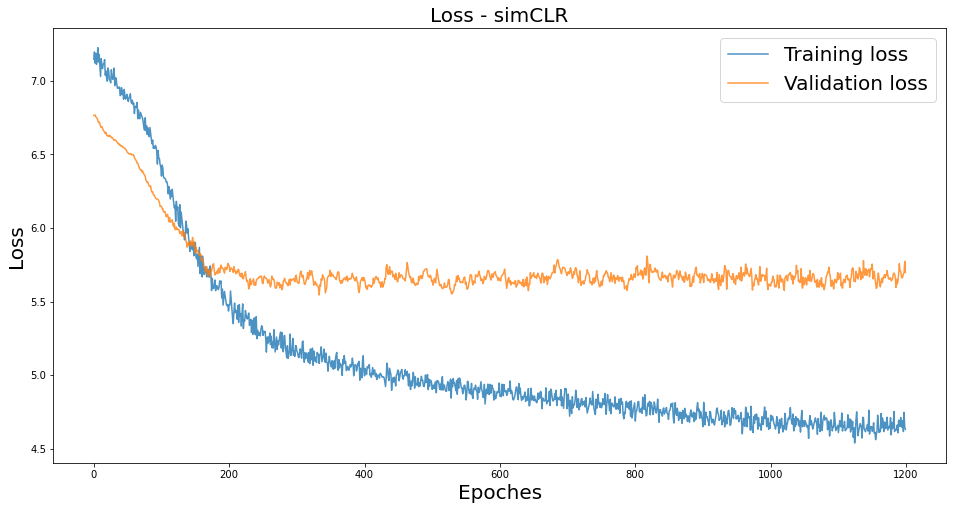

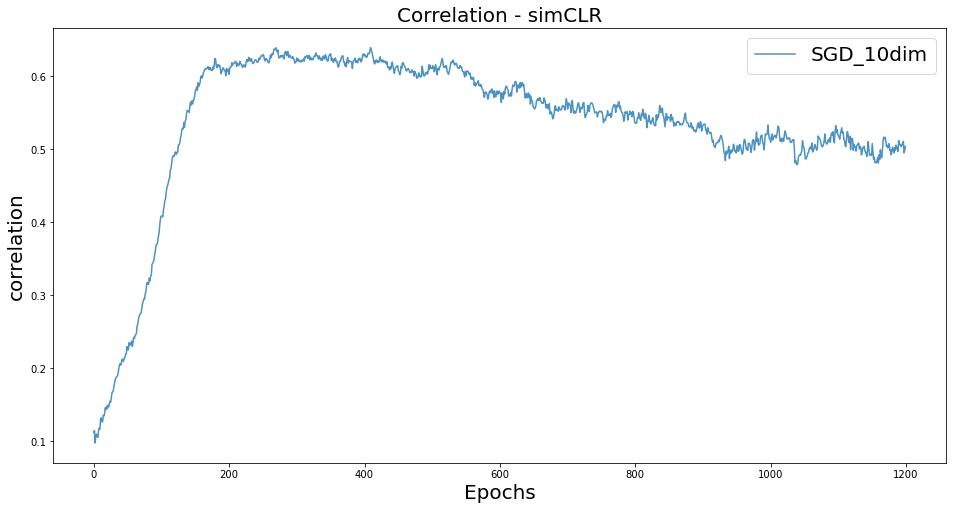

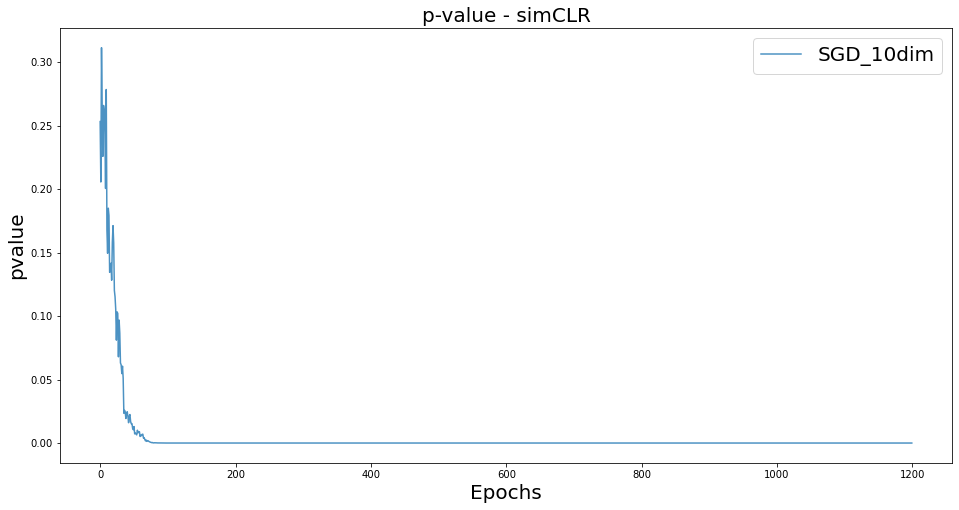

In [16]:
from plotting_utils import plot_loss
from plotting_utils import plot_training_unsup

plot_training_unsup(results=results_simCLR, model_name='simCLR')

In [17]:
### All samples 
store_embedding_unsup(index_set_simCLR[0], model_simCLR, 'all')
### Validation samples only
store_embedding_unsup(index_set_simCLR[2], model_simCLR, 'val')
### Training samples only
store_embedding_unsup(index_set_simCLR[1], model_simCLR, 'train')
### Testing samples only
store_embedding_unsup(index_set_simCLR[3], model_simCLR, 'test')